In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np
import json 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ast
from plotting import *
from sklearn.metrics import f1_score, roc_curve
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load Data


In [79]:
frames = []
for task in ['binary_abuse', 'binary_movie_sentiment']:
    path = f'../results'
    frames.append(pd.read_csv(f'{path}/{task}/results.csv'))

df = pd.concat(frames, axis = 0, ignore_index=True)

print(df.columns)


Index(['technique', 'model', 'train_runtime', 'n_train', 'n_eval', 'eval_set',
       'balanced_train', 'datetime', 'eval_true', 'eval_pred', 'seed',
       'template', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1',
       'eval_cm (tn, fp, fn, tp)', 'acc', 'f1', 'prec', 'recall', 'task'],
      dtype='object')


# Data Cleaning

In [80]:
print('\n---Pct of NaN in df columns---')
null_cols = []
for c in df.columns:
    num_na = sum(pd.isna(df[c])==True)
    if num_na !=0:
        null_cols.append(c)
    print(f"{c}: {np.round(num_na/len(df[c]),2)}%")

# Remove duplicate columns (correct results stored in ['acc', 'prec', 'recall', 'f1])
# TODO remove these things in processing_results.ipynb before 
drop_cols = ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_cm (tn, fp, fn, tp)']
df = df.drop(drop_cols, axis = 1)


---Pct of NaN in df columns---
technique: 0.0%
model: 0.0%
train_runtime: 0.0%
n_train: 0.0%
n_eval: 0.0%
eval_set: 0.0%
balanced_train: 0.0%
datetime: 0.0%
eval_true: 0.0%
eval_pred: 0.0%
seed: 0.0%
template: 0.32%
eval_accuracy: 0.32%
eval_precision: 0.32%
eval_recall: 0.32%
eval_f1: 0.32%
eval_cm (tn, fp, fn, tp): 0.32%
acc: 0.0%
f1: 0.0%
prec: 0.0%
recall: 0.0%
task: 0.0%


In [81]:
# Model Names
print('\n----MODELS----')
print(f"Original model names:\n{df['model'].value_counts()}")
model_mapping = {'distilbert':'DistilBERT', 'gpt2': 'GPT-2', 
                 'distilbert-base-cased':'DistilBERT',
                 'microsoft/deberta-v3-base':'DeBERTa-v3',
                 'LabelModel': 'LabelModel'}

df['model_name'] = df['model'].map(lambda x: model_mapping[x])

print(f"\nReplaced model names:\n{df['model_name'].value_counts()}")

print(f"\nPer technique model counts:")
for i in df['technique'].unique():
    print(f"\nTechnique: {i}\n{df['model_name'][df['technique']==i].value_counts()}")

# Techniques
print('\n----TECHNIQUES----')
print(f"Original technique names:\n{df['technique'].value_counts()}")

df['technique_name'] = df['technique'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced technique names:\n{df['technique_name'].value_counts()}")

# Tasks
print('\n----Tasks----')
print(f"Original task names:\n{df['task'].value_counts()}")

df['task_name'] = df['task'].map(lambda x: x.replace('_', " ").title())

print(f"\nReplaced task names:\n{df['task_name'].value_counts()}")

# Tasks
print('\n----Prompt Templates----')
print(f"Original prompt names:\n{df['template'].value_counts()}")

prompt_dict = {'Binary Abuse': {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text abusive? {"mask"}':'Prompt 1: Is this text abusive?',
                                '{"placeholder":"text_a"} Does this text contain abuse? {"mask"}': 'Prompt 2: Does this text contain abuse?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Abusive or Not Abusive'},
                'Binary Movie Sentiment' : {
                                np.nan:'NAN',
                                '{"placeholder":"text_a"} Is this text negative? {"mask"}': 'Prompt 1: Is this text negative?',
                                '{"placeholder":"text_a"} Does this text contain negative sentiment? {"mask"}': 'Prompt 2: Does this text contain negative sentiment?',
                                '{"placeholder":"text_a"} It was? {"mask"}' :'Prompt 3: It was? Negative or Not Negative',}
}


df['template_name'] = df.apply(lambda x: prompt_dict[x['task_name']][x['template']], axis = 1)

print(f"\nReplaced template names:\n{df['template_name'].value_counts()}")




----MODELS----
Original model names:
distilbert                   216
gpt2                         216
distilbert-base-cased         72
microsoft/deberta-v3-base     72
LabelModel                    63
Name: model, dtype: int64

Replaced model names:
DistilBERT    288
GPT-2         216
DeBERTa-v3     72
LabelModel     63
Name: model_name, dtype: int64

Per technique model counts:

Technique: transfer_learning
DistilBERT    72
DeBERTa-v3    72
Name: model_name, dtype: int64

Technique: prompt_engineering
DistilBERT    216
GPT-2         216
Name: model_name, dtype: int64

Technique: weak_supervision
LabelModel    63
Name: model_name, dtype: int64

----TECHNIQUES----
Original technique names:
prompt_engineering    432
transfer_learning     144
weak_supervision       63
Name: technique, dtype: int64

Replaced technique names:
Prompt Engineering    432
Transfer Learning     144
Weak Supervision       63
Name: technique_name, dtype: int64

----Tasks----
Original task names:
binary_abuse    

In [82]:
df['train_runtime'][df['technique_name']=='Transfer Learning'].astype(float).sort_values()

65        0.0000
44        0.0000
67        0.0000
74        0.0000
31        0.0000
         ...    
442     472.7314
445     472.8846
433     996.1687
434     996.2924
469    1000.4479
Name: train_runtime, Length: 144, dtype: float64

In [83]:
# Runtime
from datetime import timedelta, datetime

def timestr_to_float(string):
    if ':' in string:
        t = datetime.strptime(string, '%H:%M:%S.%f').time()
        seconds = int(timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())
        minutes = seconds/60
         
    else:
        # format already in seconds:
        minutes = float(string)/60

    return minutes


# # TODO: Change to  minutes or hours
df['train_runtime'] = df['train_runtime'].map(lambda x: timestr_to_float(str(x)))



In [84]:
df['train_runtime'].describe()

count    639.000000
mean       1.545439
std        2.654683
min        0.000000
25%        0.114827
50%        0.477733
75%        1.665910
max       16.674132
Name: train_runtime, dtype: float64

In [85]:
# Add experiment ID
experimental_vars = ['technique_name', 'task_name', 'balanced_train', 'template_name','model_name', 'n_train',]

# df['template'] = df['template'].map(lambda x: 'NA' if pd.isna(x)==True else x)
df = df.sort_values(by = experimental_vars)
# Group the data by the experimental variables and create a new column 'experiment_id'
df['seed_id'] = df.groupby(experimental_vars).ngroup().astype(str) + "_" + df['seed'].astype(str)
df['single_experiment_id'] = df['seed_id'].map(lambda x: x.split('_')[0])

print(f"Number of runs per experiment:\n{df['single_experiment_id'].value_counts().value_counts()}")

print(df.columns)

order = ['seed_id', 'single_experiment_id','task', 'task_name', 'technique', 'technique_name', 'model', 'model_name',
         'n_train', 'balanced_train', 'template', 'template_name', 'seed', 'eval_set','eval_true', 'eval_pred',
         'f1', 'acc', 'prec', 'recall', 'train_runtime', 'datetime']

clean_df = df[order].sort_values(by = ['single_experiment_id', 'seed_id'])


# clean_df.to_csv(f'{path}/task_results.csv', index = False)


Number of runs per experiment:
3    213
Name: single_experiment_id, dtype: int64
Index(['technique', 'model', 'train_runtime', 'n_train', 'n_eval', 'eval_set',
       'balanced_train', 'datetime', 'eval_true', 'eval_pred', 'seed',
       'template', 'acc', 'f1', 'prec', 'recall', 'task', 'model_name',
       'technique_name', 'task_name', 'template_name', 'seed_id',
       'single_experiment_id'],
      dtype='object')


# Results Processing Across Seeds and N Train

In [86]:
df = pd.read_csv(f'../results/task_results_final.csv')

print(df.columns)
drop_cols = ['task', 'model', 'technique', 'eval_set', 'template']
df = df.drop(drop_cols, axis = 1)
df.columns = [c.replace('_name', '') for c in df.columns]
print(df.columns)
df['template'] = df['template'].map(lambda x: 'NAN' if pd.isna(x)==True else x)

# Groupby experiment id to get results_vars as list across seeds
results_vars = ['eval_true', 'eval_pred', 'f1','acc', 'prec', 'recall', 'train_runtime']
experimental_vars = ['technique',  'task', 'model', 'n_train', 'balanced_train', 'template']

for c in ['eval_pred', 'eval_true']:
    df[c] = df[c].map(lambda x: ast.literal_eval(x))

grp_df = df.groupby('single_experiment_id').agg(lambda x: list(x))
for c in experimental_vars:
    grp_df[c] = grp_df[c].map(lambda x: x[0])

for v in [v for v in results_vars if 'eval' not in v]:
    grp_df[f'{v}_mean'] = grp_df[v].map(lambda x: np.array(x).mean())
    grp_df[f'{v}_std'] = grp_df[v].map(lambda x: np.array(x).std())


fixed_experimental_vars = ['technique',  'task', 'model', 'balanced_train', 'template']

exp_df = grp_df.groupby(fixed_experimental_vars).agg(lambda x: list(x)).reset_index()



Index(['seed_id', 'single_experiment_id', 'task', 'task_name', 'technique',
       'technique_name', 'model', 'model_name', 'n_train', 'balanced_train',
       'template', 'template_name', 'seed', 'eval_set', 'eval_true',
       'eval_pred', 'f1', 'acc', 'prec', 'recall', 'train_runtime',
       'datetime'],
      dtype='object')
Index(['seed_id', 'single_experiment_id', 'task', 'technique', 'model',
       'n_train', 'balanced_train', 'template', 'seed', 'eval_true',
       'eval_pred', 'f1', 'acc', 'prec', 'recall', 'train_runtime',
       'datetime'],
      dtype='object')


In [87]:
exp_df

,technique,task,model,balanced_train,template,seed_id,n_train,seed,eval_true,eval_pred,...,f1_mean,f1_std,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std
0,Prompt Engineering,Binary Abuse,DistilBERT,False,Prompt 1: Is this text abusive?,"[[0_1, 0_2, 0_3], [1_1, 1_2, 1_3], [2_1, 2_2, ...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.463094854787816, 0.46831955922865, 0.478329...","[0.0, 0.0, 0.014155641648357083, 0.03027855507...","[0.782383419689119, 0.880829015544042, 0.88054...","[0.0, 0.0, 0.00040708507840353714, 0.002115276...","[0.774582037060025, 0.775859754624285, 0.79458...","[0.0, 0.0, 0.026476578027778114, 0.01677363766...","[0.782383419689119, 0.880829015544042, 0.88054...","[0.0, 0.0, 0.00040708507840353714, 0.002115276...","[0.0, 0.029574554496341204, 0.0534849511252509...","[0.0, 0.004813575252643105, 0.0040040222235333..."
1,Prompt Engineering,Binary Abuse,DistilBERT,False,Prompt 2: Does this text contain abuse?,"[[16_1, 16_2, 16_3], [17_1, 17_2, 17_3], [18_1...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.465903566806136, 0.5067278749973766, 0.4683...","[0.0, 0.04927217428935639, 0.0, 0.012984051704...","[0.7560449050086359, 0.8762233736327003, 0.880...","[1.1102230246251565e-16, 0.006820953143968435,...","[0.775877882224837, 0.8211460706611037, 0.7758...","[0.0, 0.033522116180976544, 0.0, 0.02422466624...","[0.7560449050086359, 0.8762233736327003, 0.880...","[1.1102230246251565e-16, 0.006820953143968435,...","[0.0, 0.029032903247409397, 0.0545038951767815...","[0.0, 0.00407584702984165, 0.00434627231411965..."
2,Prompt Engineering,Binary Abuse,DistilBERT,False,Prompt 3: It was? Abusive or Not Abusive,"[[32_1, 32_2, 32_3], [33_1, 33_2, 33_3], [34_1...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.46953018687433506, 0.47071226898533763, 0.6...","[5.551115123125783e-17, 0.001779083285484084, ...","[0.801813471502591, 0.8808290155440416, 0.8759...","[0.0, 0.0003525460193990431, 0.013800424323970...","[0.777477231799566, 0.8356384896044826, 0.8546...","[0.0, 0.04880673201006441, 0.00640043707714600...","[0.801813471502591, 0.8808290155440416, 0.8759...","[0.0, 0.0003525460193990431, 0.013800424323970...","[0.0, 0.06227508783340457, 0.12349198129442034...","[0.0, 0.001391474824229538, 0.0013862114893348..."
3,Prompt Engineering,Binary Abuse,DistilBERT,True,Prompt 1: Is this text abusive?,"[[48_1, 48_2, 48_3], [49_1, 49_2, 49_3], [50_1...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.463094854787816, 0.37069138757799763, 0.479...","[0.0, 0.003924869815365763, 0.0990268879555300...","[0.782383419689119, 0.39651698330454804, 0.540...","[0.0, 0.005510705158053206, 0.1420550489697741...","[0.774582037060025, 0.8371926992302354, 0.8757...","[0.0, 0.0008943718503418139, 0.004423583945524...","[0.782383419689119, 0.39651698330454804, 0.540...","[0.0, 0.005510705158053206, 0.1420550489697741...","[0.0, 0.028874305884043466, 0.0536080188221401...","[0.0, 0.004521886646249602, 0.0044258005244974..."
4,Prompt Engineering,Binary Abuse,DistilBERT,True,Prompt 2: Does this text contain abuse?,"[[64_1, 64_2, 64_3], [65_1, 65_2, 65_3], [66_1...","[0, 16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",...,"[0.465903566806136, 0.37

In [88]:
# Global variables
n_trains = [16, 32, 64, 128, 256, 512, 1024]
seeds = [1, 2, 3]

In [89]:
exp_df['len_eval_pred'] = exp_df['eval_pred'].map(lambda x: len(x))
print(exp_df['len_eval_pred'].value_counts())

exp_df['len_eval_true'] = exp_df['eval_true'].map(lambda x: len(x))
print(exp_df['len_eval_true'].value_counts())

exp_df[exp_df['len_eval_true']==7]

8    24
7     3
Name: len_eval_pred, dtype: int64
8    24
7     3
Name: len_eval_true, dtype: int64


,technique,task,model,balanced_train,template,seed_id,n_train,seed,eval_true,eval_pred,...,acc_mean,acc_std,prec_mean,prec_std,recall_mean,recall_std,train_runtime_mean,train_runtime_std,len_eval_pred,len_eval_true
24,Weak Supervision,Binary Abuse,LabelModel,False,NAN,"[[192_1, 192_2, 192_3], [193_1, 193_2, 193_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0...",...,"[0.575129533678757, 0.479706390328152, 0.61240...","[0.0, 0.0012711227499032933, 0.003802488432246...","[0.846218417248784, 0.8664847390529057, 0.8617...","[0.0, 0.00030345919976624853, 0.00136686973956...","[0.575129533678757, 0.479706390328152, 0.61240...","[0.0, 0.0012711227499032933, 0.003802488432246...","[1.0373466444444466, 1.03976273888889, 1.05029...","[0.004312084895756313, 0.005674309352022826, 0...",7,7
25,Weak Supervision,Binary Abuse,LabelModel,True,NAN,"[[199_1, 199_2, 199_3], [200_1, 200_2, 200_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0...",...,"[0.581174438687392, 0.617012089810017, 0.64032...","[0.0, 0.0, 0.0006106276176045991, 0.0025503807...","[0.854928935304878, 0.866081495068287, 0.88816...","[0.0, 0.0, 0.0002806058448980344, 0.0003294690...","[0.581174438687392, 0.617012089810017, 0.64032...","[0.0, 0.0, 0.0006106276176045991, 0.0025503807...","[1.0483602166666666, 1.05743035, 1.03605194999...","[0.00625771929452797, 0.002889599775952113, 0....",7,7
26,Weak Supervision,Binary Movie Sentiment,LabelModel,False,NAN,"[[206_1, 206_2, 206_3], [207_1, 207_2, 207_3],...","[16, 32, 64, 128, 256, 512, 1024]","[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [...","[[[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...","[[[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1...",...,"[0.6706666666666666, 0.6610666666666667, 0.661...","[0.00037712361663283614, 0.0003771236166327838...","[0.744654011328424, 0.7601423065727494, 0.7571...","[0.001480079819607742, 0.0021045522261454214, ...","[0.6706666666666666, 0.6610666666666667, 0.661...","[0.00037712361663283614, 0.0003771236166327838...","[0.03390185555555557, 0.061351061111111105, 0....","[0.0010950676093057679, 0.0010468887247045643,...",7,7


# Learning Curves Code

In [90]:
def plot_mean_std(fig, x, mean, std, fmt, label, alpha_mean, threshold=0.5, min_alpha=0.1):
    
    alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
    color=fmt[0]
    
    plt.plot(x, mean, fmt, label=label, alpha=alpha_mean, figure=fig)
    plt.fill_between(x, mean-std, mean+std, alpha=alpha_fill, color=color, figure=fig)
                    


In [91]:
dark_colors = sns.color_palette('dark').as_hex()
bright_colors = sns.color_palette('bright').as_hex()
color_list = []
for i in [0,3,2,4,5]:
    color_list.append(dark_colors[i])
    color_list.append(bright_colors[i])

display(sns.color_palette('muted'))
display(sns.color_palette('dark'))


[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

# Global Vars

In [92]:
# paired colors
colors = [(color_list[0], color_list[1]), (color_list[2], color_list[3]), (color_list[4], color_list[5])]
linestyles = [('--', '-')]
markers = [('o', 'o'), ('X', 'X'), ('D', 'D')]
figure_orders = ['(a)', '(b)']

all_colors = sns.color_palette('dark').as_hex()
all_linestyles = ['--', '-', '-.']
all_markers = ['o', 'X', 'D', 'd']

alpha_mean = 0.7
min_alpha = 0.1
threshold = 0.5

# Learning Curves

In [93]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

def plot_learning_curves_inset(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, figure_orders,
                         alpha_mean, min_alpha, threshold, fixed_prompt = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                 (exp_df['model'].isin(techniques_models.values())) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        # single_ax.set_title(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        single_ax.set_title('Training Time', fontweight = 'semibold', fontsize = 18)
        # Set inset figure
        axins = zoomed_inset_axes(single_ax, zoom = 1.3, loc='right', borderpad=1)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (17,9), sharey = True)
        # plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        # axins_0 = zoomed_inset_axes(multi_ax[0], zoom = 1.3, loc='right', borderpad=1)
        axins_0 = inset_axes(multi_ax[0], width="30%", height="30%", loc=7, borderpad=0.2)
        # axins_1 = zoomed_inset_axes(multi_ax[1], zoom = 1.3, loc='right', borderpad=1)
        axins_1 = inset_axes(multi_ax[1], width="30%", height="30%", loc=7, borderpad=0.2)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_train']==balanced[0])&
                                (plot_df['template']==fixed_prompt)]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{tech}'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[1]}', fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]
                if j == 0:
                    axins = axins_0
                else:
                    axins = axins_1
            
            # Plot contents
            ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            ax.legend(loc='lower right', ncol = 1, fontsize = 20)
            alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
            ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
            # Plot features
            ax.grid(alpha=0.5)
            
            # Plot inset contents
            # axins.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            # # Specify the limits
            # x1, x2, y1, y2 = 0, 100, 0.36, 0.565
            # axins.set_xlim(x1, x2)
            # axins.set_ylim(y1, y2, auto=True, emit=True)
            # mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec='0.5') #ec="0.5"

            if tech == 'Weak Supervision':
                axins.plot([i for i in [16, 32, 64]], means[:3], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold #if alpha_mean > threshold else min_alpha
                axins.fill_between(xs[:3], means[:3]-stds[:3], means[:3]+stds[:3], alpha=alpha_fill, color=color)
            else:
                axins.plot([i for i in [0, 16, 32, 64]], means[:4], label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
                alpha_fill = alpha_mean - threshold #if alpha_mean > threshold else min_alpha
                axins.fill_between(xs[:4], means[:4]-stds[:4], means[:4]+stds[:4], alpha=alpha_fill, color=color)
            # ax.indicate_inset_zoom(axins)
            # plt.xlim(xmin=0, xmax=200)
            # plt.ylim(ymin=0.30, ymax=0.70)
            plt.grid()

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Training points', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

In [94]:
#TODO: Have version of graph where you can specify a lower n-train cutoff
def plot_learning_curves(PLOT_TYPE, exp_df, techniques_models, task, y_var,
                         colors, linestyles, markers, 
                         alpha_mean, min_alpha, threshold, label_loc="lower right", fixed_prompt = ""):
    
    plot_df = exp_df[exp_df['technique'].isin(techniques_models.keys()) &
                 (exp_df['model'].isin(techniques_models.values())) &
                 (exp_df['task'] == task)]

    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        # single_ax.set_title(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
        single_ax.set_title('Learning Curve', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
        plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,tech in enumerate(techniques_models.keys()):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            if tech == 'Prompt Engineering':
                line_df = plot_df[(plot_df['technique']==tech)&
                                (plot_df['balanced_train']==balanced[0])&
                                (plot_df['template']==fixed_prompt)]
            else:
                line_df = plot_df[(plot_df['technique']==tech)&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                if task == 'Binary Movie Sentiment':
                    label = f'{tech}'
                else:
                    label = f'{tech} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(balanced[1], fontweight = 'semibold', fontsize = 16)
                label = tech
                color = colors[i][0]

            # Plot contents
            ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            ax.legend(loc=label_loc, ncol = 1, fontsize = 20)
            alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
            ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
            # Plot features
            ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Training points', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

### All Techniques (F1)

/var/folders/z6/r_w_cqy92gs3f0vs5hh19p300000gr/T/ipykernel_8905/4087942613.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


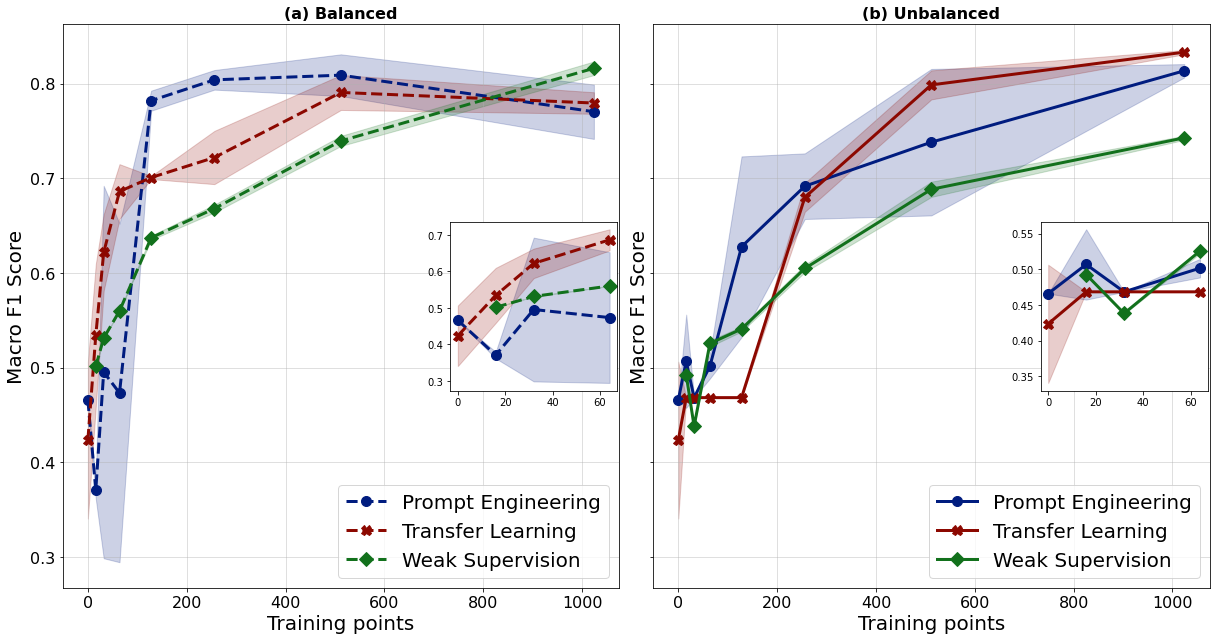

In [95]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
y_var= 'f1'

# plot_learning_curves('single panel', exp_df, techniques_models, task, y_var,
#                     colors, linestyles, markers, figure_orders,
#                     alpha_mean, min_alpha, threshold, fixed_prompt)

plot_learning_curves_inset('multi panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers, figure_orders,
                    alpha_mean, min_alpha, threshold, fixed_prompt)

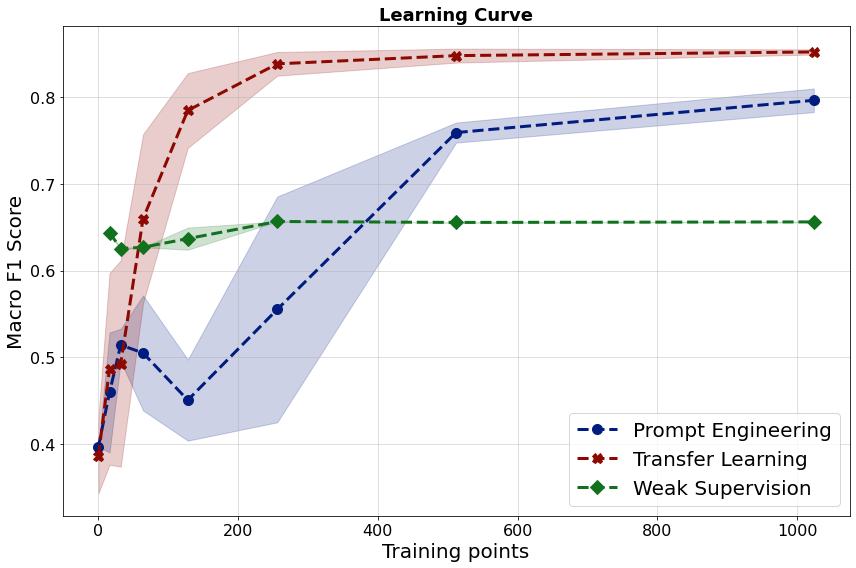

In [125]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
y_var= 'f1'

plot_learning_curves('single panel', exp_df, techniques_models, task, y_var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'lower right', fixed_prompt)

### All Techniques (training time)

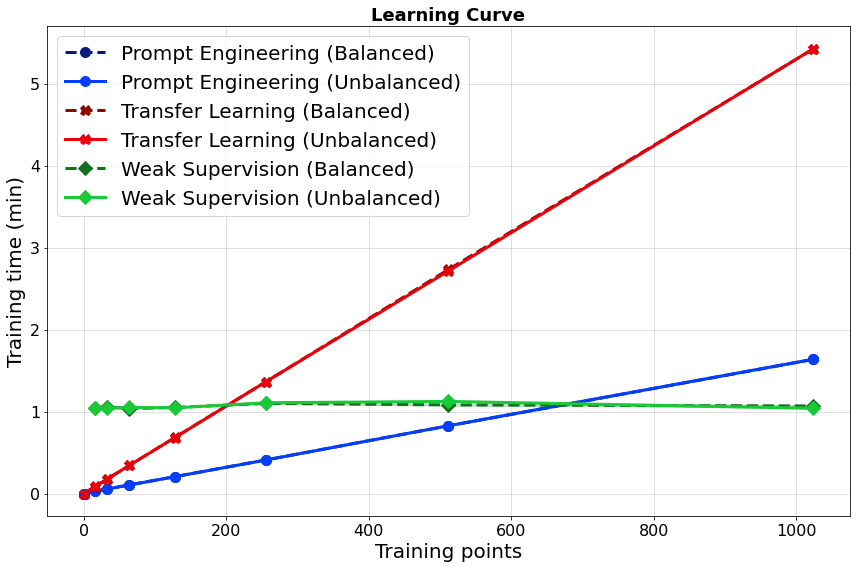

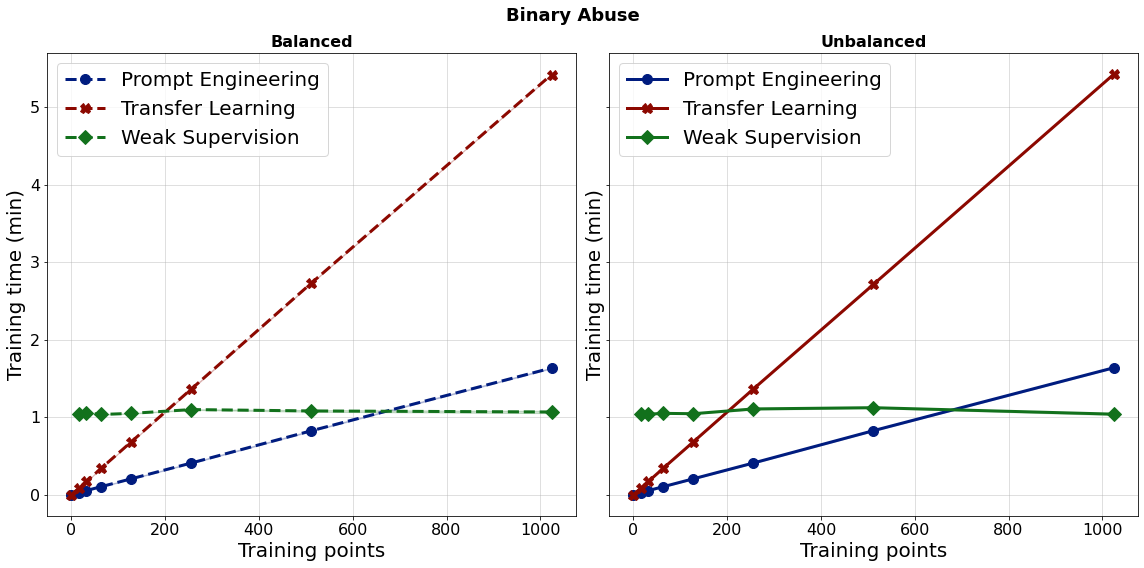

In [98]:
task = 'Binary Abuse'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain abuse?'
var= 'train_runtime'

plot_learning_curves('single panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt)

plot_learning_curves('multi panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt)

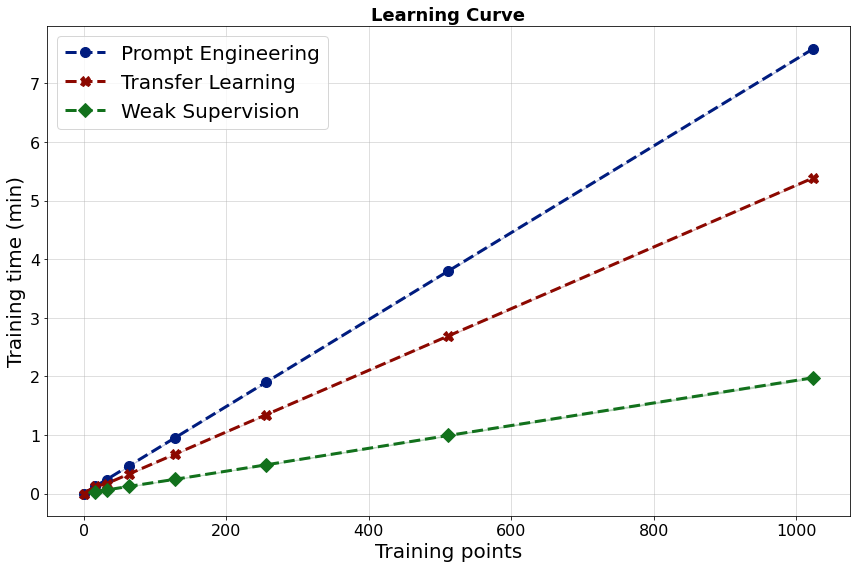

In [99]:
task = 'Binary Movie Sentiment'
techniques_models = {'Prompt Engineering':'DistilBERT', 
                     'Transfer Learning':'DistilBERT', 
                     'Weak Supervision':'LabelModel'}

# prompt used for prompt engineering
fixed_prompt = 'Prompt 2: Does this text contain negative sentiment?'
var= 'train_runtime'

plot_learning_curves('single panel', exp_df, techniques_models, task, var,
                    colors, linestyles, markers,
                    alpha_mean, min_alpha, threshold, 'upper left', fixed_prompt)

# Plot Single Technique By Split Var


In [116]:
#TODO: Have version of graph where you can specify a lower n-train cutoff


def plot_learning_curves_by_split_var_multi(PLOT_TYPE, exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold):

    plot_df = exp_df[(exp_df['technique']==technique)]
    fixed_var_dict = base_variable_values[technique]
    for col, fixed_v in fixed_var_dict.items():
        if col!=split_var:
            plot_df = plot_df[plot_df[col].isin(fixed_v)]
    values = plot_df[split_var].unique()
    task = base_variable_values[technique]['task'][0]


    if PLOT_TYPE == 'single panel':
        single_fig, single_ax = plt.subplots(1,1, figsize = (12,8))
        single_ax.set_title(f'{technique} by {split_var.capitalize()}', fontweight = 'semibold', fontsize = 18)
    else:
        multi_fig, multi_ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
        # plt.suptitle(plot_df['task'].unique()[0], fontweight = 'semibold', fontsize = 18)
    if task == 'Binary Movie Sentiment':
        balanced_type = [[False, "Balanced"]]
    else:
        balanced_type = [[True, "Balanced"], [False, "Unbalanced"]]
    for i,val in enumerate(values):
        for j, balanced in enumerate(balanced_type):
            # Subset dataframe
            line_df = plot_df[(plot_df[split_var]==val)&(plot_df['balanced_train']==balanced[0])]
            
            # Set arrays
            xs = np.array(line_df['n_train'].to_list()[0])
            means = np.array(line_df[f'{y_var}_mean'].to_list()[0])
            stds = np.array(line_df[f'{y_var}_std'].to_list()[0])

            # Plot set-up
            linestyle = linestyles[0][j]
            marker = markers[i][j]
            if PLOT_TYPE == 'single panel':
                ax = single_ax
                label = f'{val} ({balanced[1]})'
                color = colors[i][j]
            else:
                ax = multi_ax[j]
                ax.set_title(f'{figure_orders[j]} {balanced[1]}', fontweight = 'semibold', fontsize = 16)
                label = val
                color = colors[i][0]

            # Plot contents
            ax.plot(xs, means, label = label, markersize = 10, marker = marker, color=color, linestyle=linestyle, linewidth =3)
            if split_var == 'template':
                ax.legend(loc='lower right', ncol = 1, fontsize = 16)
            else:
                ax.legend(loc='lower right', ncol = 1, fontsize = 20)
            alpha_fill = alpha_mean - threshold if alpha_mean > threshold else min_alpha
            ax.fill_between(xs, means-stds, means+stds, alpha=alpha_fill, color=color)
            # Plot features
            ax.grid(alpha=0.5)

            # Axis properties
            ax.tick_params(axis = 'both', labelsize=16)
            ax.set_xlabel('Training points', fontsize = 20)
            if y_var == 'train_runtime':
                ax.set_ylabel('Training time (min)', fontsize = 20)
            elif y_var == 'f1':
                ax.set_ylabel('Macro F1 Score', fontsize = 20)
            else:
                ax.set_ylabel(y_var.capitalize(), fontsize = 20)

    plt.tight_layout()
    plt.show()

In [117]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Abuse'],
                        'template': ['Prompt 2: Does this text contain abuse?',
                                    'Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT']},

                        'Transfer Learning':{'task': ['Binary Abuse'],
                        'model':['DistilBERT']},

                        'Weak Supervision':{'task': ['Binary Abuse'],
                        'model':['LabelModel']},


}

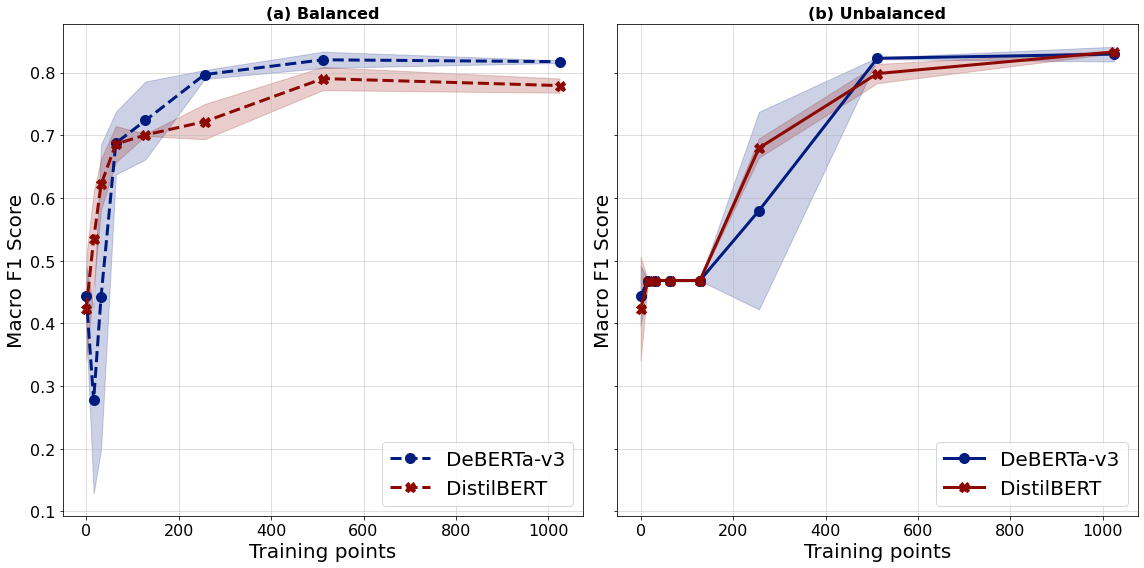

In [118]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

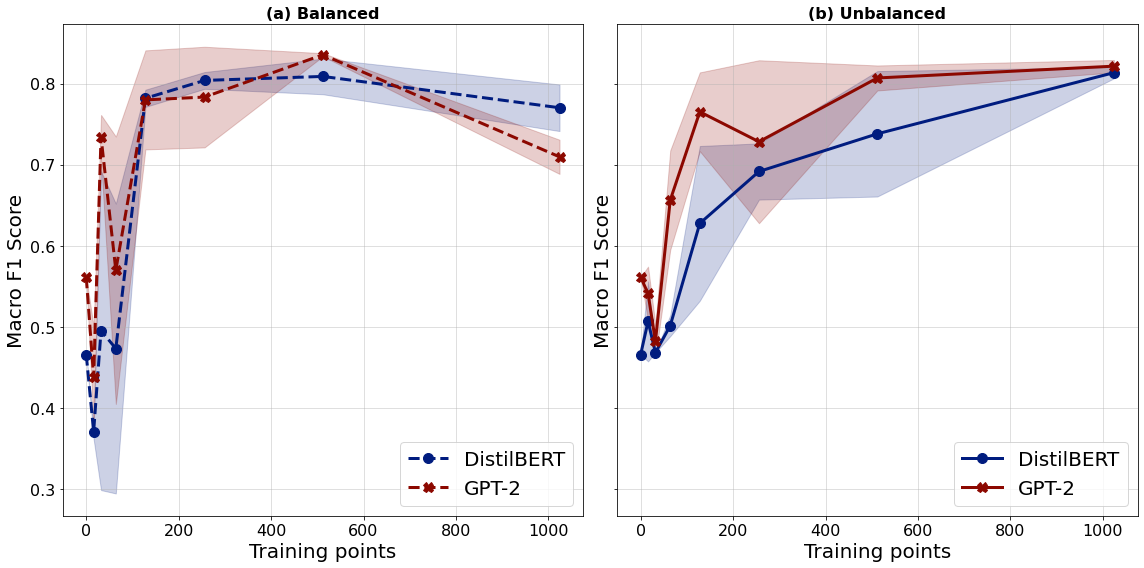

In [119]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

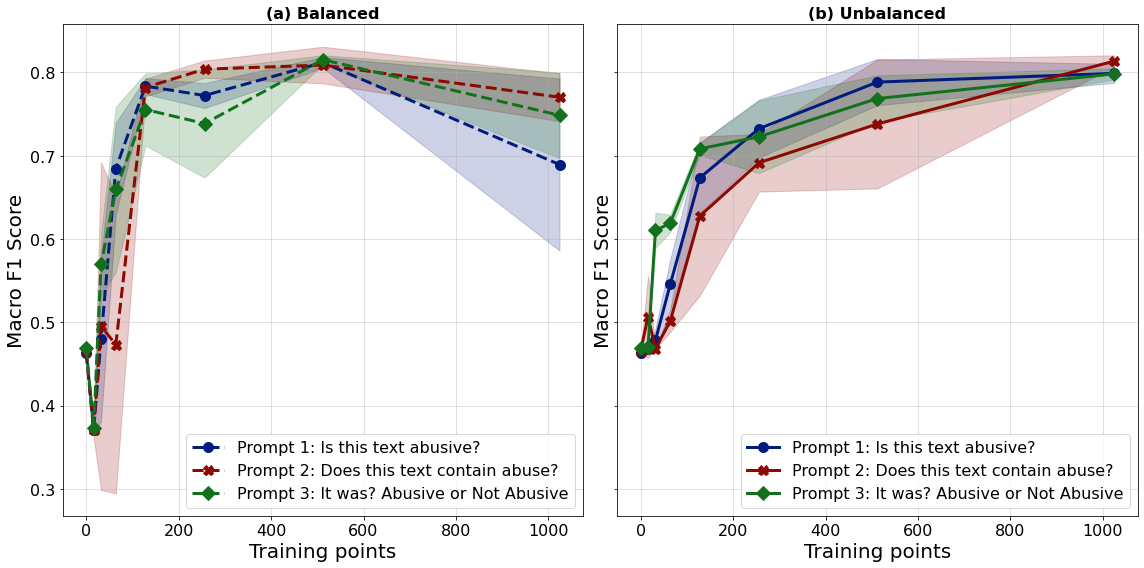

In [120]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('multi panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

In [121]:
# SET FIXED VALUES
base_variable_values = {'Prompt Engineering':{'task': ['Binary Movie Sentiment'],
                        'template': ['Prompt 2: Does this text contain negative sentiment?',
                                     ],
                        'model':['DistilBERT']},

                        'Transfer Learning':{'task': ['Binary Movie Sentiment'],
                        'model':['DistilBERT']},

                        'Weak Supervision':{'task': ['Binary Movie Sentiment'],
                        'model':['LabelModel']},


}

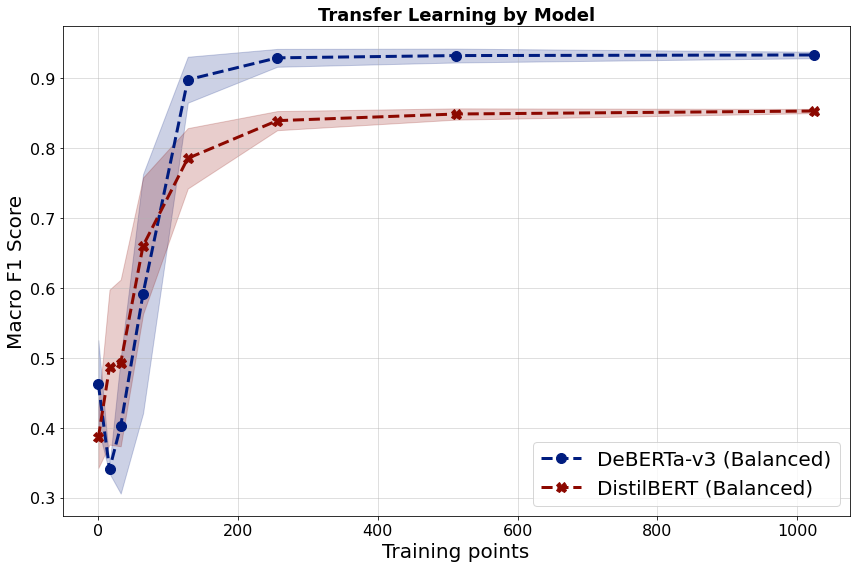

In [122]:
split_var = 'model'
y_var = 'f1'
technique = 'Transfer Learning'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

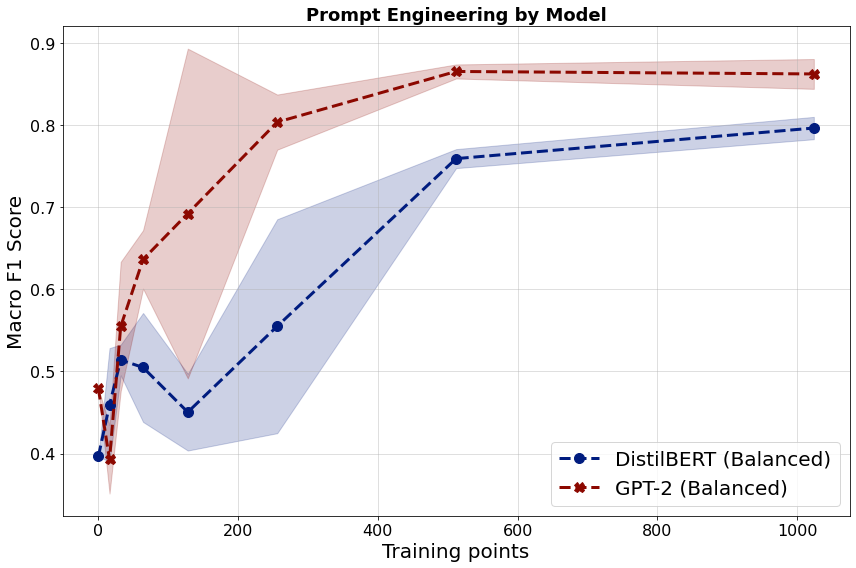

In [123]:
split_var = 'model'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)

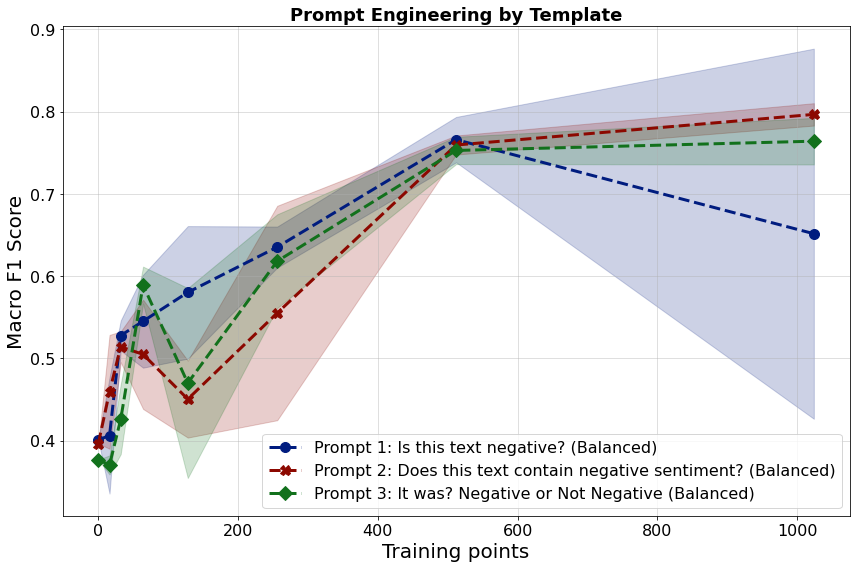

In [124]:
split_var = 'template'
y_var = 'f1'
technique = 'Prompt Engineering'

plot_learning_curves_by_split_var_multi('single panel', exp_df, split_var, technique, y_var,
                         colors, linestyles, markers, figure_orders, 
                         alpha_mean, min_alpha, threshold)